Starting Change Detection Script...
GPU found! Using CUDA.

--- Step 1: Loading Data ---
正在从 /kaggle/input/dataset-revier/dataset zuixin/river_before.mat 加载 'river_before'...
  -> 加载的数据形状: (463, 241, 198), 数据类型: int16
正在从 /kaggle/input/dataset-revier/dataset zuixin/river_after.mat 加载 'river_after'...
  -> 加载的数据形状: (463, 241, 198), 数据类型: int16
正在从 /kaggle/input/dataset-revier/dataset zuixin/groundtruth.mat 加载 'lakelabel_v1'...
  -> 加载的数据形状: (463, 241), 数据类型: uint8
Detected 198 bands/channels in the input images.

--- Step 2: Preprocessing Data ---
正在归一化形状为 (463, 241, 198) 的图像...
  -> 归一化完成。输出范围: 0.00 到 1.00
正在归一化形状为 (463, 241, 198) 的图像...
  -> 归一化完成。输出范围: 0.00 到 1.00
Ground truth binarized. Change pixels (1.0): 9698.0, No change pixels (0.0): 101885
Data shapes after processing (C, H, W):
  Before: torch.Size([198, 463, 241])
  After:  torch.Size([198, 463, 241])
  GT:     torch.Size([1, 463, 241])

--- Step 3: Extracting Patches ---
正在从尺寸为 (198, 463, 241) 的图像中提取 9x9 的图像块，步长为 3...
  -> 

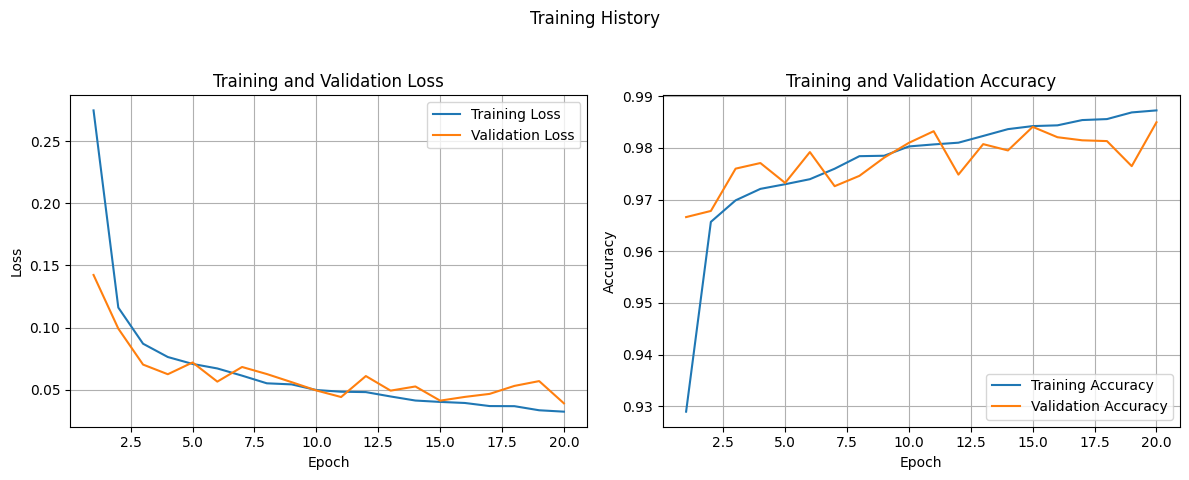


--- Step 7: Evaluating Model on Test Set ---
Loading best model weights from results_simplified_cn/best_change_detection_model_cn.pth

--- Evaluating on Test Set ---


<ipython-input-3-a32c886a58a0>:773: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


Test Loss: 0.0376
Test Accuracy: 0.9856
Test Precision: 0.9501
Test Recall: 0.8774
Test F1 Score: 0.9123
Confusion matrix saved to results_simplified_cn/test_test_confusion_matrix_en_plots_cn_comments.png


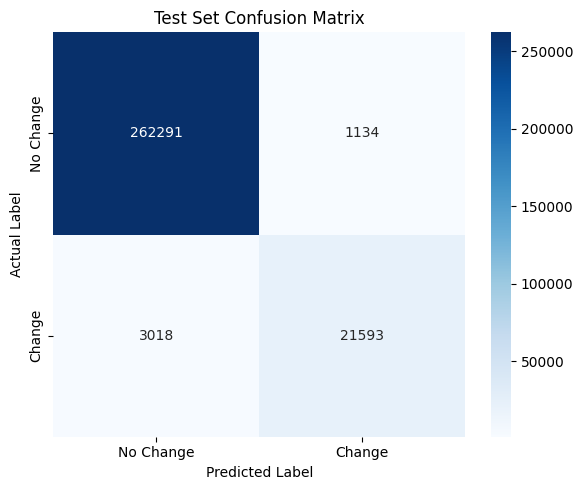


--- Step 8: Predicting on Full Image ---

--- Predicting full image using 11856 patches ---
  Processed batch 18/186
  Processed batch 36/186
  Processed batch 54/186
  Processed batch 72/186
  Processed batch 90/186
  Processed batch 108/186
  Processed batch 126/186
  Processed batch 144/186
  Processed batch 162/186
  Processed batch 180/186
--- Full image prediction finished ---

--- Step 9: Visualizing Full Image Results ---
Result comparison plot saved to results_simplified_cn/full_image_prediction_en_plots_cn_comments.png


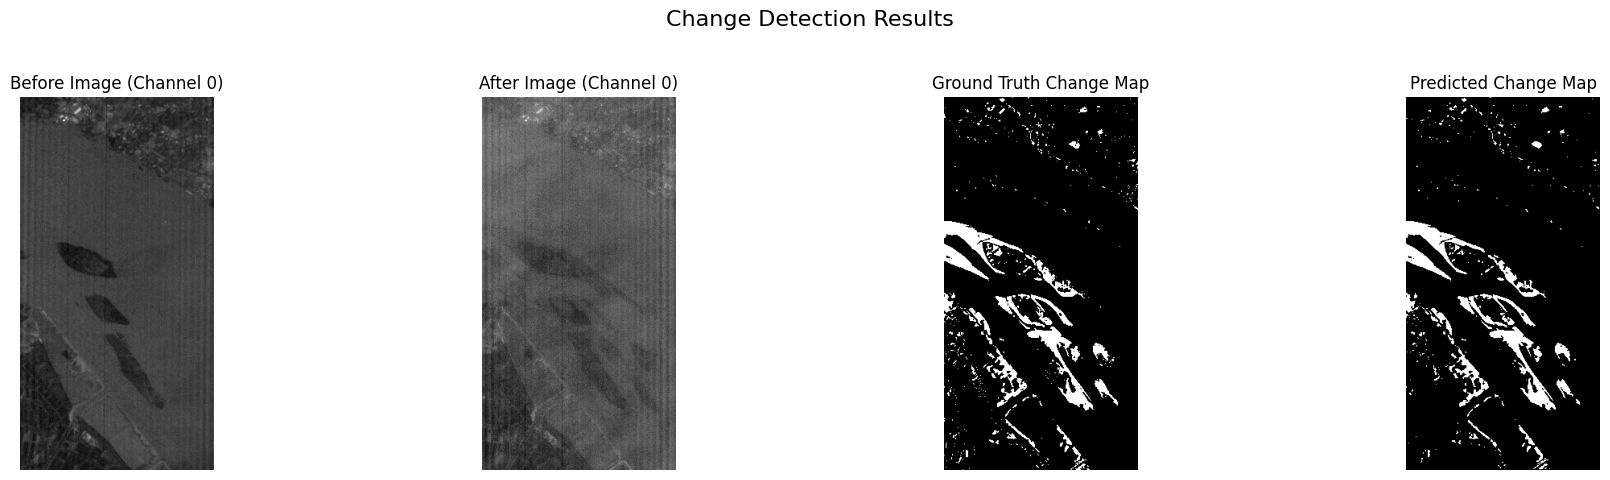


--- Optional: Calculating Metrics on Full Prediction ---
Full Image Accuracy: 0.9892
Full Image Precision: 0.9727
Full Image Recall: 0.9009
Full Image F1 Score: 0.9354

--- Script Finished Successfully! ---


In [3]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.nn.functional as F # 用于激活函数、填充等
from torch.utils.data import DataLoader, TensorDataset # 用于处理数据批次
from torch.optim import Adam # 一种流行的优化器

from scipy.io import loadmat # 用于从 .mat 文件加载数据
from pathlib import Path # 用于方便地处理文件路径
import numpy as np
from sklearn.model_selection import train_test_split # 用于划分数据集
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix # 用于评估模型
import matplotlib.pyplot as plt
import seaborn as sns # 用于绘制漂亮的混淆矩阵

# --- 基本配置 ---
# 定义你的数据存放位置和结果保存位置
# !! 重要：请将此路径更新为你的 .mat 文件所在的文件夹 !!
BASE_DATA_PATH = Path('/kaggle/input/dataset-revier/dataset zuixin') # 或者你的本地路径
SAVE_RESULTS_PATH = Path('results_simplified_cn') # 用于保存模型和图表的文件夹

# 数据文件的名称
BEFORE_FILE = 'river_before.mat'
AFTER_FILE = 'river_after.mat'
GT_FILE = 'groundtruth.mat' # 地面真实标签（Ground Truth）文件

# 模型和图表保存的名称
BEST_MODEL_NAME = 'best_change_detection_model_cn.pth'
TRAINING_PLOT_NAME = 'training_loss_accuracy_en_plots_cn_comments.png' # 文件名包含en_plots表示图片内容是英文
PREDICTION_PLOT_NAME = 'full_image_prediction_en_plots_cn_comments.png'
CONFUSION_MATRIX_NAME = 'test_confusion_matrix_en_plots_cn_comments.png' # 混淆矩阵文件名

# 数据参数
# 我们假设 .mat 文件内部的变量名是这些：
BEFORE_VAR = 'river_before'
AFTER_VAR = 'river_after'
GT_VAR = 'lakelabel_v1'
GT_CHANGE_VALUE = 255 # 在地面真实标签文件中，代表“变化”的值

# 图像块提取参数 (如何将图像切割成小块用于训练)
PATCH_SIZE = 9 # 小方形图像块的大小 (例如 9x9 像素)
STRIDE = 3     # 提取下一个图像块时移动的像素数。stride < patch_size 意味着图像块会重叠。

# 训练参数
TEST_SPLIT_RATIO = 0.3  # 使用 30% 的数据进行测试
VALIDATION_SPLIT_RATIO = 0.2 # 使用 20% 的数据进行验证（在训练期间检查进度）
# 注意：训练数据将是 1.0 - 0.3 - 0.2 = 50%
RANDOM_SEED = 42        # 确保每次运行时数据划分都相同
BATCH_SIZE = 64         # 训练期间一次处理的图像块数量
EPOCHS = 20             # 遍历整个训练数据集的次数
LEARNING_RATE = 0.001   # 模型在训练期间调整其权重的幅度

# 预测参数
PREDICTION_THRESHOLD = 0.5 # 用于判断一个像素是“变化”还是“无变化”的概率阈值

# --- 辅助函数 ---

# 从 .mat 文件加载数据的函数
def load_mat_data(file_path, variable_name):
    """从 .mat 文件中加载特定变量的数据。"""
    print(f"正在从 {file_path} 加载 '{variable_name}'...")
    try:
        # loadmat 返回一个字典，我们获取指定的变量
        data = loadmat(file_path)[variable_name]
        print(f"  -> 加载的数据形状: {data.shape}, 数据类型: {data.dtype}")
        # 将 numpy 数组转换为 PyTorch 张量 (使用 float32 以兼容模型)
        return torch.tensor(data, dtype=torch.float32)
    except FileNotFoundError:
        print(f"错误：文件未在 {file_path} 找到")
        exit() # 如果找不到数据则停止脚本
    except KeyError:
        print(f"错误：变量 '{variable_name}' 未在 {file_path} 中找到")
        exit()
    except Exception as e:
        print(f"加载 {file_path} 时发生意外错误: {e}")
        exit()

# 归一化图像数据的函数
def normalize_image(image_tensor):
    """将一个张量 (H, W, C) 归一化，使每个通道的值都在 0 和 1 之间。"""
    if image_tensor.ndim != 3:
        print(f"错误：归一化需要一个 3D 张量 (高, 宽, 通道数)，但得到的是 {image_tensor.ndim}D")
        exit()

    h, w, n_channels = image_tensor.shape
    print(f"正在归一化形状为 ({h}, {w}, {n_channels}) 的图像...")

    normalized_image = torch.zeros_like(image_tensor) # 创建一个相同大小的空张量

    # 分别归一化每个通道
    for c in range(n_channels):
        channel_data = image_tensor[:, :, c]
        min_val = torch.min(channel_data)
        max_val = torch.max(channel_data)

        if max_val - min_val > 0:
            normalized_image[:, :, c] = (channel_data - min_val) / (max_val - min_val)
        else:
            # 如果最小值和最大值相同（通道数据全一样），则设置为 0 或 0.5
            normalized_image[:, :, c] = 0.0

    print(f"  -> 归一化完成。输出范围: {normalized_image.min():.2f} 到 {normalized_image.max():.2f}")
    return normalized_image

# 从图像中提取图像块的函数
def extract_patches(image, patch_size=PATCH_SIZE, stride=STRIDE):
    """从图像 (C, H, W) 中提取带重叠的方形图像块。"""
    # 输入图像应为 (通道数, 高, 宽) 格式
    if image.ndim != 3:
        print(f"错误：提取图像块需要一个 3D 张量 (通道数, 高, 宽)，但得到的是 {image.ndim}D")
        exit()

    C, H, W = image.shape
    print(f"正在从尺寸为 ({C}, {H}, {W}) 的图像中提取 {patch_size}x{patch_size} 的图像块，步长为 {stride}...")

    patches = []
    # 计算最后一个图像块的中心可以离边缘多远
    center_offset = patch_size // 2

    # 遍历图像块可能的中心像素
    # 从内侧 `center_offset` 像素开始，到距离边缘 `center_offset` 像素结束
    for i in range(center_offset, H - center_offset, stride):
        for j in range(center_offset, W - center_offset, stride):
            # 计算图像块的左上角坐标
            top = i - center_offset
            left = j - center_offset
            # 提取图像块：所有通道，从 `top` 到 `top+patch_size` 行，`left` 到 `left+patch_size` 列
            patch = image[:, top : top + patch_size, left : left + patch_size]

            # 再次检查图像块大小（使用此循环应该总是正确的）
            if patch.shape[1] == patch_size and patch.shape[2] == patch_size:
                patches.append(patch)
            else:
                 print(f"警告：由于意外的大小 {patch.shape}，跳过了中心在 ({i},{j}) 的图像块。这不应该发生。")

    if not patches:
        print("警告：没有提取到任何图像块。请检查图像尺寸、图像块大小和步长。")
        return torch.empty((0, C, patch_size, patch_size), dtype=image.dtype, device=image.device)

    print(f"  -> 提取了 {len(patches)} 个图像块。")
    # 将所有提取的图像块堆叠成一个张量 (图像块数量, C, H, W)
    return torch.stack(patches)

# --- 模型定义 (简化的 Siamese U-Net) ---

# 基本构建块：卷积 -> 批归一化 -> 激活函数
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # 卷积层，kernel_size=3, padding=1 保持特征图大小不变
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        # 批归一化有助于稳定训练
        self.bn = nn.BatchNorm2d(out_channels)
        # ReLU 是一种常用的激活函数
        self.relu = nn.ReLU(inplace=True) # inplace=True 可以节省一点内存

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

# 编码器部分：对图像进行下采样，提取特征
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = ConvBlock(in_channels, out_channels)
        self.conv2 = ConvBlock(out_channels, out_channels)
        # 最大池化层将图像尺寸缩小 (高/2, 宽/2)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # 我们返回池化后的输出（用于进入更深层）和池化前的输出（用于跳跃连接）
        return self.pool(x), x

# 解码器部分：对图像进行上采样，并与编码器的特征结合
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        # 转置卷积层对图像进行上采样 (高*2, 宽*2)
        # 它试图学习卷积/池化操作的逆过程
        self.up = nn.ConvTranspose2d(in_channels, skip_channels, kernel_size=2, stride=2)
        # 结合上采样特征和跳跃连接特征后的卷积层
        # 输入通道数 = 上采样后的通道数 + 跳跃连接的通道数
        self.conv1 = ConvBlock(skip_channels + skip_channels, out_channels)
        self.conv2 = ConvBlock(out_channels, out_channels)

    def forward(self, x, skip_connection):
        x = self.up(x) # 上采样

        # 有时，由于池化操作，跳跃连接的尺寸可能与上采样后的尺寸略有不同。
        # 我们需要使它们匹配。这里，如果上采样后的张量 `x` 较小，我们对其进行填充。
        diff_h = skip_connection.size(2) - x.size(2) # 高度差
        diff_w = skip_connection.size(3) - x.size(3) # 宽度差
        if diff_h > 0 or diff_w > 0:
            # F.pad 的参数是 [左填充, 右填充, 上填充, 下填充]
            x = F.pad(x, [diff_w // 2, diff_w - diff_w // 2, # 填充左/右
                           diff_h // 2, diff_h - diff_h // 2]) # 填充上/下

        # 沿着通道维度拼接上采样的特征和跳跃连接的特征
        # dim=1 表示通道维度 (N, C, H, W)
        x = torch.cat([skip_connection, x], dim=1)

        x = self.conv1(x)
        x = self.conv2(x)
        return x

# 主要的变化检测模型，使用两个类 U-Net 的分支 (Siamese)
class ChangeDetectionUNet(nn.Module):
    def __init__(self, input_channels, num_classes=1): # num_classes=1 用于二元分类（变化/无变化）
        super().__init__()

        # 定义每一层的特征数量
        features = [64, 128, 256] # 为了简单起见，层数较少

        # --- 编码器分支 1 (用于 'before' 图像) ---
        self.enc1_br1 = EncoderBlock(input_channels, features[0]) # 例如，198 -> 64 通道
        self.enc2_br1 = EncoderBlock(features[0], features[1])    # 例如，64 -> 128 通道

        # --- 编码器分支 2 (用于 'after' 图像) ---
        self.enc1_br2 = EncoderBlock(input_channels, features[0]) # 例如，198 -> 64 通道
        self.enc2_br2 = EncoderBlock(features[0], features[1])    # 例如，64 -> 128 通道

        # --- 瓶颈层 (最深的部分) ---
        # 获取两个分支的特征，并将它们组合起来（这里使用绝对差）
        # 输入通道数基于单个分支的输出大小
        self.bottleneck_conv1 = ConvBlock(features[1], features[2]) # 128 -> 256
        self.bottleneck_conv2 = ConvBlock(features[2], features[1]) # 256 -> 128，输出通道数与解码器输入匹配

        # --- 解码器 ---
        # 获取瓶颈层的输出和跳跃连接（从两个分支组合而来）
        # 输入来自瓶颈层，跳跃连接来自 enc2
        self.dec2 = DecoderBlock(features[1], features[1], features[1])
        # 输入来自 dec2，跳跃连接来自 enc1
        self.dec1 = DecoderBlock(features[1], features[0], features[0])

        # --- 最终输出层 ---
        # 使用 1x1 卷积将特征映射到所需的输出类别数量（二元分类为 1）
        self.output_conv = nn.Conv2d(features[0], num_classes, kernel_size=1)

    def forward(self, x1, x2): # x1 是 'before' 图像, x2 是 'after' 图像
        # --- 分支 1 ---
        pool1_1, skip1_1 = self.enc1_br1(x1)
        pool1_2, skip1_2 = self.enc2_br1(pool1_1)

        # --- 分支 2 ---
        pool2_1, skip2_1 = self.enc1_br2(x2)
        pool2_2, skip2_2 = self.enc2_br2(pool2_1)

        # --- 瓶颈层 ---
        # 融合两个分支最深部分的特征
        # 我们可以使用绝对差来突出变化
        fused_pool = torch.abs(pool1_2 - pool2_2)
        bottle_out = self.bottleneck_conv1(fused_pool)
        bottle_out = self.bottleneck_conv2(bottle_out)

        # --- 解码器 ---
        # 融合跳跃连接（同样使用绝对差）
        skip_fused_2 = torch.abs(skip1_2 - skip2_2)
        skip_fused_1 = torch.abs(skip1_1 - skip2_1)

        # 使用融合后的跳跃连接将数据传递给解码器块
        up2 = self.dec2(bottle_out, skip_fused_2)
        up1 = self.dec1(up2, skip_fused_1)

        # --- 最终输出 ---
        output = self.output_conv(up1)

        # 应用 sigmoid 函数得到 0 到 1 之间的概率
        return torch.sigmoid(output)

# --- 训练函数 ---
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    """训练模型并跟踪损失和准确率。"""

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_val_loss = float('inf') # 初始化为一个非常大的值

    print(f"\n--- 开始在 {device} 上进行 {epochs} 轮训练 ---")

    for epoch in range(epochs):
        # --- 训练阶段 ---
        model.train() # 将模型设置为训练模式 (启用 dropout, 更新 batch norm 统计)
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        # 遍历训练数据加载器中的每个批次
        for batch_idx, (x1_batch, x2_batch, y_batch) in enumerate(train_loader):
            # 将数据移动到目标设备 (GPU 或 CPU)
            x1_batch, x2_batch, y_batch = x1_batch.to(device), x2_batch.to(device), y_batch.to(device)

            # 1. 清除上一步的梯度
            optimizer.zero_grad()

            # 2. 前向传播：获取模型预测结果
            outputs = model(x1_batch, x2_batch)

            # 3. 计算损失
            # criterion 是损失函数，例如 BCELoss
            # outputs 是模型预测 (概率)，y_batch 是真实标签 (0 或 1)
            loss = criterion(outputs, y_batch)

            # 处理潜在的 NaN (非数字) 损失
            if torch.isnan(loss):
                print(f"警告：在第 {epoch+1} 轮，第 {batch_idx} 批次检测到 NaN 损失。跳过此批次。")
                continue # 跳过此批次的反向传播

            # 4. 反向传播：计算梯度
            loss.backward()

            # 5. 优化器步骤：更新模型权重
            optimizer.step()

            # --- 跟踪训练统计数据 ---
            # loss.item() 是该批次的平均损失，乘以批次大小得到批次总损失
            running_train_loss += loss.item() * x1_batch.size(0)

            # 计算该批次的准确率
            predicted = (outputs > PREDICTION_THRESHOLD).float() # 将概率转换为 0 或 1
            total_train += y_batch.numel() # 批次标签中的像素总数
            correct_train += (predicted == y_batch).sum().item() # 计算预测正确的像素数量

        # 计算整个训练轮次的平均损失和准确率
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        epoch_train_acc = correct_train / total_train

        # --- 验证阶段 ---
        model.eval() # 将模型设置为评估模式 (禁用 dropout, 使用 batch norm 的运行统计数据)
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad(): # 在验证期间禁用梯度计算 (节省内存和计算量)
            for x1_batch, x2_batch, y_batch in val_loader:
                x1_batch, x2_batch, y_batch = x1_batch.to(device), x2_batch.to(device), y_batch.to(device)

                outputs = model(x1_batch, x2_batch)
                loss = criterion(outputs, y_batch)

                if torch.isnan(loss):
                    print(f"警告：在第 {epoch+1} 轮验证期间检测到 NaN 损失。跳过此批次的损失计算。")
                    continue

                running_val_loss += loss.item() * x1_batch.size(0)

                predicted = (outputs > PREDICTION_THRESHOLD).float()
                total_val += y_batch.numel()
                correct_val += (predicted == y_batch).sum().item()

        # 计算整个验证轮次的平均损失和准确率
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        # 防止 total_val 为 0 的情况
        epoch_val_acc = correct_val / total_val if total_val > 0 else 0


        # --- 记录结果并保存最佳模型 ---
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}")

        # 将本轮结果添加到历史记录
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        # 如果验证损失有所改善，则保存模型
        # 同时检查验证损失是否为 NaN
        if epoch_val_loss < best_val_loss and not np.isnan(epoch_val_loss):
            best_val_loss = epoch_val_loss
            save_path = SAVE_RESULTS_PATH / BEST_MODEL_NAME
            # 保存模型的 state_dict (包含所有可学习的参数)
            torch.save(model.state_dict(), save_path)
            print(f"  -> Model improved! Saved to {save_path}")

    print("--- 训练完成 ---")
    return model, history

# --- 评估函数 ---
@torch.no_grad() # 装饰器，禁用梯度计算
def evaluate_model(model, data_loader, criterion, device, dataset_name="Test"):
    """在给定的数据集（例如测试集）上评估模型。"""
    model.eval() # 设置为评估模式
    total_loss = 0.0
    all_preds = [] # 存储所有预测结果
    all_labels = [] # 存储所有真实标签

    print(f"\n--- Evaluating on {dataset_name} Set ---") # 使用英文
    for x1_batch, x2_batch, y_batch in data_loader:
        # 将数据移到设备
        x1_batch, x2_batch, y_batch = x1_batch.to(device), x2_batch.to(device), y_batch.to(device)

        # 前向传播
        outputs = model(x1_batch, x2_batch)
        # 计算损失
        loss = criterion(outputs, y_batch)

        if torch.isnan(loss):
            print(f"Warning: NaN loss detected during {dataset_name} evaluation. Skipping batch.") # 使用英文
            continue

        # 累加损失
        total_loss += loss.item() * x1_batch.size(0)

        # 存储预测结果和标签 (移动到 CPU 以便后续使用 sklearn 计算指标)
        all_preds.append(outputs.cpu())
        all_labels.append(y_batch.cpu())

    if not all_preds: # 如果没有任何有效批次被处理
        print(f"Error: No valid batches processed during {dataset_name} evaluation.") # 使用英文
        return None # 表示评估失败

    # 计算平均损失
    avg_loss = total_loss / len(data_loader.dataset)

    # 将所有批次的结果拼接起来
    all_preds_tensor = torch.cat(all_preds)
    all_labels_tensor = torch.cat(all_labels)

    # 将概率转换为二元预测 (0 或 1)，并展平以便 sklearn 计算指标
    preds_binary = (all_preds_tensor > PREDICTION_THRESHOLD).float().numpy().flatten()
    labels_binary = all_labels_tensor.numpy().flatten()

    # 计算各种评估指标
    accuracy = accuracy_score(labels_binary, preds_binary)
    # zero_division=0 防止出现除以零的警告 (当某个类别没有被预测出来时)
    precision = precision_score(labels_binary, preds_binary, zero_division=0)
    recall = recall_score(labels_binary, preds_binary, zero_division=0)
    f1 = f1_score(labels_binary, preds_binary, zero_division=0)
    # 计算混淆矩阵
    cm = confusion_matrix(labels_binary, preds_binary)

    # 打印评估结果 (使用英文)
    print(f"{dataset_name} Loss: {avg_loss:.4f}")
    print(f"{dataset_name} Accuracy: {accuracy:.4f}")
    print(f"{dataset_name} Precision: {precision:.4f}")
    print(f"{dataset_name} Recall: {recall:.4f}")
    print(f"{dataset_name} F1 Score: {f1:.4f}")

    # 绘制混淆矩阵 (使用英文)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Change', 'Change'], yticklabels=['No Change', 'Change']) # 标签用英文
    plt.title(f'{dataset_name} Set Confusion Matrix') # 标题用英文
    plt.ylabel('Actual Label') # Y轴标签用英文
    plt.xlabel('Predicted Label') # X轴标签用英文
    plt.tight_layout() # 调整布局防止标签重叠
    # 保存混淆矩阵图像
    # 文件名本身在配置中定义，这里是打印信息
    cm_save_path = SAVE_RESULTS_PATH / f"{dataset_name.lower()}_{CONFUSION_MATRIX_NAME}"
    plt.savefig(cm_save_path)
    # 打印保存路径信息（使用英文）
    print(f"Confusion matrix saved to {cm_save_path}")
    plt.show() # 显示图像

    # 返回包含所有指标的字典
    return {'loss': avg_loss, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}


# --- 整图预测函数 ---
@torch.no_grad() # 预测时不需要计算梯度
def predict_full_image(model, before_img_tensor, after_img_tensor, device, patch_size=PATCH_SIZE, stride=STRIDE, batch_size=BATCH_SIZE):
    """使用滑动窗口方法预测整个图像的变化图。"""
    model.eval() # 设置为评估模式
    C, H, W = before_img_tensor.shape # 获取图像尺寸 (通道数, 高, 宽)

    # 确保输入图像在正确的设备上 (GPU 或 CPU)
    before_img_tensor = before_img_tensor.to(device)
    after_img_tensor = after_img_tensor.to(device)

    # 创建占位符张量，用于存储预测结果的总和和计数的映射，以便进行平均
    # 预测结果是单通道的 (变化概率)
    pred_accumulator = torch.zeros((1, H, W), dtype=torch.float32, device=device)
    # count_map 记录每个像素被多少个图像块覆盖（预测）过
    count_map = torch.zeros((1, H, W), dtype=torch.float32, device=device)

    # 生成每个图像块左上角的坐标
    patch_coords = []
    # 确保不会超出图像边界
    for i in range(0, H - patch_size + 1, stride):
        for j in range(0, W - patch_size + 1, stride):
             patch_coords.append((i, j)) # (行坐标, 列坐标)

    if not patch_coords:
        print(f"Error: No valid patch coordinates for prediction. Check image size ({H},{W}), patch size ({patch_size}), stride ({stride}).") # 使用英文
        return torch.zeros((1, H, W), dtype=torch.float32) # 返回全零图

    # 使用英文打印信息
    print(f"\n--- Predicting full image using {len(patch_coords)} patches ---")
    # 计算总共需要多少个批次
    num_batches = (len(patch_coords) + batch_size - 1) // batch_size

    # 按批次处理图像块
    for k in range(num_batches):
        # 获取当前批次的坐标
        start_idx = k * batch_size
        end_idx = min((k + 1) * batch_size, len(patch_coords))
        batch_coords = patch_coords[start_idx:end_idx]

        if not batch_coords: continue # 如果批次为空则跳过

        # 从已在设备上的完整图像张量中提取当前批次的图像块
        # 这种切片操作在 GPU 上是高效的
        before_batch = torch.stack([before_img_tensor[:, i:i+patch_size, j:j+patch_size] for i, j in batch_coords])
        after_batch = torch.stack([after_img_tensor[:, i:i+patch_size, j:j+patch_size] for i, j in batch_coords])

        # 对当前批次的图像块进行预测
        # 输出形状: (批次大小, 1, 图像块高, 图像块宽)
        pred_patches = model(before_batch, after_batch)

        # 将预测结果累加到累加器中，并更新计数映射
        for idx, (i, j) in enumerate(batch_coords):
            # 将第 idx 个预测图像块加到累加器对应的位置
            pred_accumulator[:, i:i+patch_size, j:j+patch_size] += pred_patches[idx]
            # 将计数映射对应位置的值加 1
            count_map[:, i:i+patch_size, j:j+patch_size] += 1

        # 大约打印 10 次进度信息 (使用英文)
        if (k + 1) % (max(1, num_batches // 10)) == 0:
            print(f"  Processed batch {k+1}/{num_batches}")

    # 对重叠区域的预测结果进行平均
    # 防止除以零（在 count_map 为 0 的区域，理论上如果 stride <= patch_size 不会发生）
    count_map[count_map == 0] = 1.0
    final_pred_prob = pred_accumulator / count_map # 逐元素相除

    # 将概率图转换为二元图 (0 或 1)
    final_pred_binary = (final_pred_prob > PREDICTION_THRESHOLD).float()
    print("--- Full image prediction finished ---") # 使用英文

    # 返回二元预测图（它位于计算设备上，通常是 GPU）
    return final_pred_binary


# --- 可视化函数 ---

def plot_training_history(history, save_path):
    """绘制训练和验证过程中的损失和准确率变化曲线。"""
    epochs_range = range(1, len(history['train_loss']) + 1) # 轮次数

    plt.figure(figsize=(12, 5)) # 设置图像大小

    # 绘制损失曲线 (使用英文标签)
    plt.subplot(1, 2, 1) # 1行2列的第一个子图
    plt.plot(epochs_range, history['train_loss'], label='Training Loss')
    plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss') # 英文标题
    plt.xlabel('Epoch') # 英文X轴标签
    plt.ylabel('Loss') # 英文Y轴标签
    plt.grid(True) # 显示网格

    # 绘制准确率曲线 (使用英文标签)
    plt.subplot(1, 2, 2) # 1行2列的第二个子图
    plt.plot(epochs_range, history['train_acc'], label='Training Accuracy')
    plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy') # 英文标题
    plt.xlabel('Epoch') # 英文X轴标签
    plt.ylabel('Accuracy') # 英文Y轴标签
    plt.grid(True)

    plt.suptitle('Training History') # 英文总标题
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 调整布局，防止标题重叠
    plt.savefig(save_path) # 保存图像
    # 使用英文打印保存信息
    print(f"Training history plot saved to {save_path}")
    plt.show() # 显示图像

def visualize_results(before_img, after_img, gt_map, pred_map, save_path):
    """可视化 Before, After, 地面真实标签和预测结果图。"""
    fig, axes = plt.subplots(1, 4, figsize=(20, 5)) # 创建 1 行 4 列的子图
    fig.suptitle('Change Detection Results', fontsize=16) # 英文总标题

    # 决定显示哪个通道 (例如，第一个通道)
    display_channel = 0

    # 确保张量在 CPU 上并且是 numpy 数组以便绘图
    # 使用 .squeeze() 移除单维度 (例如 GT 和 Pred 的通道维度)
    # .cpu() 将张量移到 CPU, .numpy() 转换为 NumPy 数组
    im_before = before_img[display_channel].cpu().numpy()
    im_after = after_img[display_channel].cpu().numpy()
    im_gt = gt_map.squeeze().cpu().numpy()
    im_pred = pred_map.squeeze().cpu().numpy()

    # 显示 Before 图像 (使用英文标题)
    axes[0].imshow(im_before, cmap='gray') # 使用灰度色彩映射
    axes[0].set_title(f'Before Image (Channel {display_channel})')
    axes[0].axis('off') # 关闭坐标轴

    # 显示 After 图像 (使用英文标题)
    axes[1].imshow(im_after, cmap='gray')
    axes[1].set_title(f'After Image (Channel {display_channel})')
    axes[1].axis('off')

    # 显示 Ground Truth 图 (使用英文标题)
    axes[2].imshow(im_gt, cmap='gray')
    axes[2].set_title('Ground Truth Change Map')
    axes[2].axis('off')

    # 显示 Prediction 图 (使用英文标题)
    axes[3].imshow(im_pred, cmap='gray')
    axes[3].set_title('Predicted Change Map')
    axes[3].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 调整布局
    plt.savefig(save_path, dpi=200) # 以指定分辨率保存图像
    # 使用英文打印保存信息
    print(f"Result comparison plot saved to {save_path}")
    plt.show() # 显示图像

# ==============================================================================
# 主执行模块
# ==============================================================================
if __name__ == "__main__": # 确保代码只在直接运行时执行

    print("Starting Change Detection Script...") # 使用英文

    # --- 设置 ---
    # 创建结果文件夹（如果不存在），parents=True 允许创建多级目录
    SAVE_RESULTS_PATH.mkdir(parents=True, exist_ok=True)

    # 设置设备 (如果 GPU 可用则使用 GPU，否则使用 CPU)
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print("GPU found! Using CUDA.") # 使用英文
    else:
        device = torch.device('cpu')
        print("GPU not found. Using CPU.") # 使用英文

    # 为了可复现性，设置随机种子
    torch.manual_seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    if device == torch.device('cuda'):
        torch.cuda.manual_seed_all(RANDOM_SEED) # 为所有 GPU 设置种子

    # --- 1. 数据加载 (在 CPU 上进行) ---
    # 标题使用英文
    print("\n--- Step 1: Loading Data ---")
    before_data_cpu = load_mat_data(BASE_DATA_PATH / BEFORE_FILE, BEFORE_VAR)
    after_data_cpu = load_mat_data(BASE_DATA_PATH / AFTER_FILE, AFTER_VAR)
    gt_data_cpu = load_mat_data(BASE_DATA_PATH / GT_FILE, GT_VAR)

    # 从加载的数据中获取通道数/波段数 (假设 loadmat 加载后是 H, W, C 格式)
    if before_data_cpu.ndim != 3:
        # 错误信息使用英文
        print(f"Error: Expected 'before' data to be 3D (H, W, C), but got {before_data_cpu.ndim}D")
        exit()
    NUM_BANDS = before_data_cpu.shape[2]
    # 使用英文打印信息
    print(f"Detected {NUM_BANDS} bands/channels in the input images.")

    # --- 2. 数据预处理 (在 CPU 上进行) ---
    # 标题使用英文
    print("\n--- Step 2: Preprocessing Data ---")
    # 归一化图像
    before_norm_cpu = normalize_image(before_data_cpu)
    after_norm_cpu = normalize_image(after_data_cpu)

    # 二值化地面真实标签 (GT): 1 表示变化, 0 表示无变化
    # gt_data_cpu 可能是 (H, W)，需要符合二值化逻辑
    # (gt_data_cpu == GT_CHANGE_VALUE) 会产生布尔值 (True/False)
    # .float() 将其转换为浮点数 (1.0 / 0.0)
    gt_binary_cpu = (gt_data_cpu == GT_CHANGE_VALUE).float()
    # 使用英文打印信息
    print(f"Ground truth binarized. Change pixels (1.0): {torch.sum(gt_binary_cpu).item()}, No change pixels (0.0): {torch.sum(gt_binary_cpu == 0).item()}")

    # 将图像维度转换为 PyTorch 标准格式: (通道数, 高, 宽)
    before_processed_cpu = before_norm_cpu.permute(2, 0, 1)
    after_processed_cpu = after_norm_cpu.permute(2, 0, 1)
    # 为地面真实标签添加一个通道维度: (高, 宽) -> (1, 高, 宽)
    gt_processed_cpu = gt_binary_cpu.unsqueeze(0)

    # 使用英文打印信息
    print(f"Data shapes after processing (C, H, W):")
    print(f"  Before: {before_processed_cpu.shape}")
    print(f"  After:  {after_processed_cpu.shape}")
    print(f"  GT:     {gt_processed_cpu.shape}")

    # --- 3. 提取图像块 (在 CPU 上进行) ---
    # 标题使用英文
    print("\n--- Step 3: Extracting Patches ---")
    before_patches = extract_patches(before_processed_cpu, PATCH_SIZE, STRIDE)
    after_patches = extract_patches(after_processed_cpu, PATCH_SIZE, STRIDE)
    gt_patches = extract_patches(gt_processed_cpu, PATCH_SIZE, STRIDE)

    # 确保所有输入提取了相同数量的图像块
    if not (len(before_patches) == len(after_patches) == len(gt_patches)):
        # 错误信息使用英文
        print("Error: Mismatch in number of extracted patches. Check extraction logic or input data.")
        print(f"Before: {len(before_patches)}, After: {len(after_patches)}, GT: {len(gt_patches)}")
        exit()
    if len(before_patches) == 0:
        # 错误信息使用英文
        print("Error: Zero patches were extracted. Check parameters and image size.")
        exit()

    # 使用英文打印信息
    print(f"Total patches extracted: {len(before_patches)}")
    print(f"Patch shapes: Before: {before_patches.shape}, After: {after_patches.shape}, GT: {gt_patches.shape}")

    # --- 4. 创建数据集和数据加载器 ---
    # 标题使用英文
    print("\n--- Step 4: Creating Datasets and DataLoaders ---")
    # 从图像块创建数据集 (数据仍在 CPU 上)
    full_dataset = TensorDataset(before_patches, after_patches, gt_patches)

    # 将数据集划分为训练集、验证集和测试集
    num_samples = len(full_dataset)
    test_size = int(TEST_SPLIT_RATIO * num_samples)
    val_size = int(VALIDATION_SPLIT_RATIO * num_samples)
    train_size = num_samples - test_size - val_size

    # 使用英文打印信息
    print(f"Splitting data: Train ({train_size}), Validation ({val_size}), Test ({test_size})")
    try:
        # 先分出训练集和（验证集+测试集）
        train_dataset, temp_dataset = train_test_split(full_dataset, test_size=(test_size + val_size), random_state=RANDOM_SEED)
        # 再从 temp_dataset 中分出验证集和测试集
        val_dataset, test_dataset = train_test_split(temp_dataset, test_size=test_size, random_state=RANDOM_SEED)
    except ValueError as e:
         # 错误信息使用英文
         print(f"Error during data splitting: {e}. Not enough samples maybe?")
         exit()

    # 使用英文打印信息
    print(f"Actual sizes: Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")

    # 创建 DataLoader 来处理批次化加载
    # num_workers=0 表示数据加载在主进程中进行 (更简单，适合初学者)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    # 使用英文打印信息
    print("DataLoaders created.")

    # --- 5. 设置模型、损失函数、优化器 ---
    # 标题使用英文
    print("\n--- Step 5: Setting up Model, Loss, Optimizer ---")
    # 初始化模型
    # NUM_BANDS 是之前检测到的通道数
    model = ChangeDetectionUNet(input_channels=NUM_BANDS).to(device) # 将模型移动到 GPU 或 CPU
    # 使用英文打印信息
    print(f"Model initialized on {device}.")

    # 定义损失函数 (二元交叉熵损失适用于二元分类)
    criterion = nn.BCELoss()
    # 使用英文打印信息
    print("Loss function: Binary Cross Entropy (BCELoss)")

    # 定义优化器 (Adam 是一个不错的默认选择)
    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
    # 使用英文打印信息
    print(f"Optimizer: Adam with Learning Rate {LEARNING_RATE}")

    # --- 6. 训练模型 ---
    # train_model 函数处理训练循环和保存最佳模型
    model, training_history = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=EPOCHS)

    # 绘制训练历史曲线
    plot_training_history(training_history, save_path=SAVE_RESULTS_PATH / TRAINING_PLOT_NAME)

    # --- 7. 在测试集上评估模型 ---
    # 标题使用英文
    print("\n--- Step 7: Evaluating Model on Test Set ---")
    # 加载训练过程中保存的最佳模型权重
    best_model_path = SAVE_RESULTS_PATH / BEST_MODEL_NAME
    if best_model_path.exists():
        # 使用英文打印信息
        print(f"Loading best model weights from {best_model_path}")
        # map_location=device 确保模型加载到正确的设备上
        model.load_state_dict(torch.load(best_model_path, map_location=device))
    else:
        # 使用英文打印信息
        print("Warning: Best model file not found. Evaluating with the final model state.")

    # 在从未见过的数据（测试集）上评估模型性能
    test_metrics = evaluate_model(model, test_loader, criterion, device, dataset_name="Test")

    # --- 8. 在整张图像上进行预测 ---
    # 标题使用英文
    print("\n--- Step 8: Predicting on Full Image ---")
    # 使用之前处理好的完整图像 (它们仍在 CPU 上)
    # predict_full_image 函数会根据需要将它们移动到设备。
    predicted_change_map = predict_full_image(
        model,
        before_processed_cpu, # 传递 (C, H, W) 形状的 CPU 张量
        after_processed_cpu,  # 传递 (C, H, W) 形状的 CPU 张量
        device,
        patch_size=PATCH_SIZE,
        stride=STRIDE,         # 使用与训练时相同的步长以保持一致性
        batch_size=BATCH_SIZE
    )

    # --- 9. 可视化整图结果 ---
    # 标题使用英文
    print("\n--- Step 9: Visualizing Full Image Results ---")
    # 可视化原始图像、地面真实标签和模型的预测结果
    visualize_results(
        before_processed_cpu, # 仍在 CPU 上
        after_processed_cpu,  # 仍在 CPU 上
        gt_processed_cpu,     # 仍在 CPU 上
        predicted_change_map, # 这个张量在 'device' 上 (GPU/CPU), visualize_results 会处理移动到 CPU
        save_path=SAVE_RESULTS_PATH / PREDICTION_PLOT_NAME
    )

    # --- 可选：计算整图指标 ---
    # 标题使用英文
    print("\n--- Optional: Calculating Metrics on Full Prediction ---")
    # 将 GT 和预测结果展平成一维数组以计算整体指标
    gt_flat = gt_processed_cpu.cpu().numpy().flatten() # 确保在 CPU 上并转为 NumPy
    pred_flat = predicted_change_map.cpu().numpy().flatten() # 确保在 CPU 上并转为 NumPy

    # 计算指标
    full_accuracy = accuracy_score(gt_flat, pred_flat)
    full_precision = precision_score(gt_flat, pred_flat, zero_division=0)
    full_recall = recall_score(gt_flat, pred_flat, zero_division=0)
    full_f1 = f1_score(gt_flat, pred_flat, zero_division=0)

    # 使用英文打印结果
    print(f"Full Image Accuracy: {full_accuracy:.4f}")
    print(f"Full Image Precision: {full_precision:.4f}")
    print(f"Full Image Recall: {full_recall:.4f}")
    print(f"Full Image F1 Score: {full_f1:.4f}")

    # 使用英文打印结束信息
    print("\n--- Script Finished Successfully! ---")